# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

### Overview of Data

In [ ]:
X = pd.read_csv('./data/X_train.csv')
y = pd.read_csv('./data/y_train.csv')

# Every row in dataset has unique ID so carries no useful information
X = X.drop('id', axis=1)
y = y.drop('id', axis=1)

# General information
print(f'X has {X.shape[0]} data points, each with {X.shape[1]} features')
print(f'y has {y.shape[0]} labels')
print()

# Information about y
print('max(y): ', y.y.max())
print('min(y): ', y.y.min())
print(f'mean(y): {y.y.mean():.2f}')
print(f'std(y): {y.y.std():.2f}')

#### Missing Data

In [ ]:
# Information about missing features
X_nan_count = X.isna().sum()
print(f'Maximum missing values: {X_nan_count.max()}/{X.shape[0]}')
print(f'Minimum missing values: {X_nan_count.min()}/{X.shape[0]}')
print('Average missing values: ', X_nan_count.mean())
print('Std missing values:, ', X_nan_count.std())

print()

# Information about missing labels
print(f'There are {int(y.y.isna().sum())} missing labels')

#### Feature Selection

Drop every feature column which has only zero entries.

Drop every duplicate feature column.


In [ ]:
# spot feature columns with only zero or empty entries
zero_feature_cols = X.columns[(X.isna() | (X == 0.0)).all()]
print(f'Dropping {len(zero_feature_cols)} feature columns with only zero or empty entries.')
X_select = X.drop(zero_feature_cols, axis=1)
# drop duplicate feature columns
dup_feats = X_select.T.duplicated()
dup_samples = X_select.duplicated()
print(f'Dropping {dup_feats.sum()} duplicate feature columns and {dup_samples.sum()} duplicate sample rows.')
# drop duplicate features
X_select = X_select.loc[:, ~dup_feats]
print(f'After feature selection, X has {X_select.shape[1]} features remaining.')
# drop duplicate samples
X_select = X_select.loc[~dup_samples, :]
y_select = y.loc[~dup_samples, :]
print(f'After dropping duplicate samples, X has {X_select.shape[0]} data points remaining.')

### Visualizing Outlier Detection Boundaries with PCA

To assess the behavior of different outlier detection methods on the dataset, we can visualize their decision boundaries in a 2D space using PCA.
This allows us to see how each method classifies data points as inliers or outliers based on the original high-dimensional data.


In [15]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Import functions from your script
from train import imputation, outlier_detection, configs, OutlierDetector, Imputer

# Import the specific detectors for 2D training
from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN
from scipy import stats
from sklearn.svm import OneClassSVM

%matplotlib inline

def plot_pca_boundary(X_imputed, y, outlier_method, configs):
    """
    Trains a 2D outlier detector on PCA-transformed data to visualize the
    decision boundary.

    It also plots the data points, colored by the labels from the *original*
    832-dimensional outlier detector, to see how they compare.
    """
    print(f"--- Visualizing: {outlier_method.value} ---")

    # 1. Set config for the *original* 832-D detector
    # === MODIFICATION: Use new nested config structure ===
    if 'outlier_detector' not in configs:
         configs['outlier_detector'] = {}

    configs['outlier_detector']['method'] = outlier_method

    # 2. Get outlier labels from the *original* 832-D data
    original_detector_func = outlier_detection(X_imputed, y)
    original_keep_mask = original_detector_func(X_imputed)

    # 3. Scale and apply PCA to reduce to 2D
    scaler = StandardScaler()
    n_components = 2 # configs['outlier_detector']['pca_n_components']
    pca = PCA(n_components=n_components, random_state=configs['random_state'])

    X_scaled = scaler.fit_transform(X_imputed)
    X_pca = pca.fit_transform(X_scaled)

    # 4. Train a *new* 2D outlier detector (just for visualization)
    if outlier_method is OutlierDetector.ISOFOREST:
        detector_2d = IsolationForest(contamination=0.05, random_state=configs["random_state"])
        detector_2d.fit(X_pca)
        predict_fn = lambda x: detector_2d.predict(x) # 1 inlier, -1 outlier

    elif outlier_method is OutlierDetector.KNN:
        detector_2d = KNN(contamination=0.05)
        detector_2d.fit(X_pca)
        predict_fn = lambda x: detector_2d.predict(x) * -2 + 1 # Convert 0/1 to 1/-1

    elif outlier_method is OutlierDetector.ZSCORE:
        mean_2d = np.nanmean(X_pca, axis=0)
        std_2d = np.nanstd(X_pca, axis=0)
        std_2d[std_2d == 0] = 1.0

        # Use a reasonable threshold for the 2D plot
        zscore_thresh_2d = 2.0

        def zscore_predict(x):
            zscores = np.abs((x - mean_2d) / std_2d)
            is_inlier = np.mean(zscores, axis=1) <= zscore_thresh_2d
            return is_inlier.astype(int) * 2 - 1 # Convert True/False to 1/-1

        predict_fn = zscore_predict

    elif outlier_method is OutlierDetector.SVM:
        detector_2d = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
        detector_2d.fit(X_pca)
        predict_fn = lambda x: detector_2d.predict(x) # 1 inlier, -1 outlier

    elif outlier_method is OutlierDetector.PCA_SVM:
        # train svm on 2d pca data
        detector_2d = OneClassSVM(nu=configs['outlier_detector']['pca_svm_nu'], kernel='rbf', gamma=configs['outlier_detector']['pca_svm_gamma'])
        detector_2d.fit(X_pca)
        predict_fn = lambda x: detector_2d.predict(x) # 1 inlier, -1 outlier

    elif outlier_method is OutlierDetector.PCA_ISOFOREST:
        detector_2d = IsolationForest(contamination=configs['outlier_detector']['pca_isoforest_contamination'], random_state=configs["random_state"])
        detector_2d.fit(X_pca)
        predict_fn = lambda x: detector_2d.predict(x) # 1 inlier, -1 outlier

    # 5. Create meshgrid to plot the 2D boundary
    xx, yy = np.meshgrid(
        np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 100),
        np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 100)
    )
    Z = predict_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 6. Plot the results
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)

    plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    # Use the 'original_keep_mask' to color the points
    plot_df['Status'] = np.where(original_keep_mask, 'Inlier', 'Outlier (from 832-D)')

    sns.scatterplot(
        data=plot_df,
        x='PC1',
        y='PC2',
        hue='Status',
        style='Status',
        palette={'Inlier': 'blue', 'Outlier (from 832-D)': 'red'},
        alpha=0.8
    )

    plt.title(f"PCA of Data with 2D '{outlier_method.value}' Decision Boundary\nPoints colored by original 832-D detector")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

In [16]:
# 1. Load data
x_training_data = pd.read_csv("./data/X_train.csv", skiprows=1, header=None).values[:, 1:]
y_training_data = (pd.read_csv("./data/y_train.csv", skiprows=1, header=None).values[:, 1:].ravel())

# 3. Run imputation *once* on all data
print(f"Running imputation ({configs['impute_method'].value})...")
imputer = imputation(x_training_data, i=None) # i=None to skip model loading
X_imputed = imputer.transform(x_training_data)
print("Imputation complete.")

Running imputation (mean)...
Imputation complete.


--- Visualizing: isoForest ---
Using IsolationForest (stateful, contamination=0.05)
INFO: OutlierDetector.ISOFOREST (on train data) found 61 outliers. Keeping 1151 / 1212 samples.


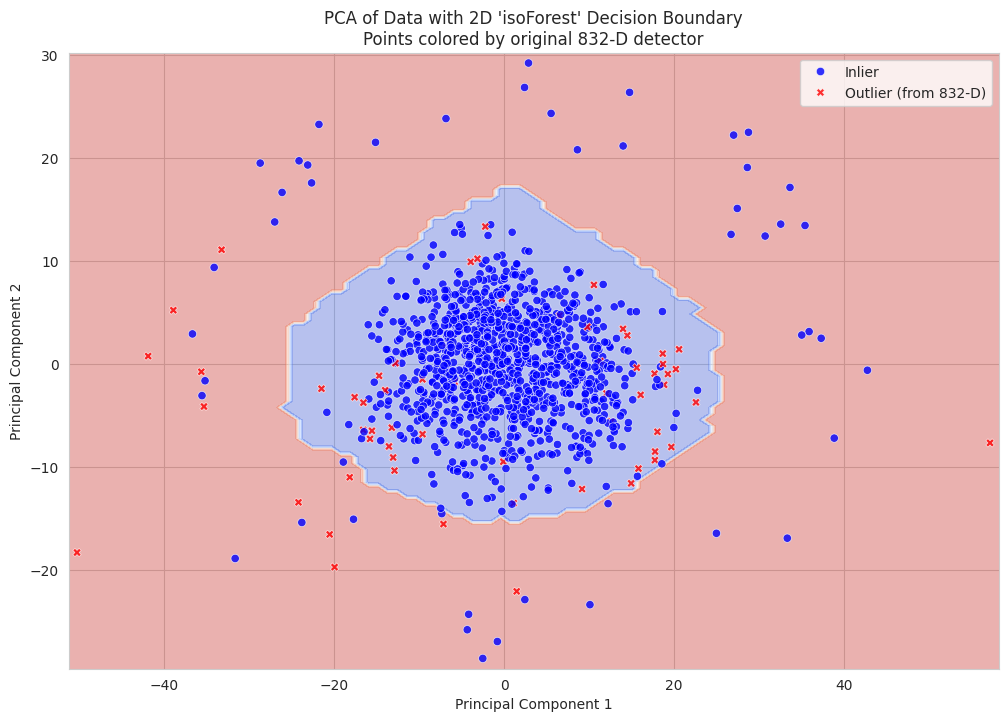

--- Visualizing: knn ---
Using KNN detector (stateful, contamination=0.05)
INFO: OutlierDetector.KNN (on train data) found 46 outliers. Keeping 1166 / 1212 samples.


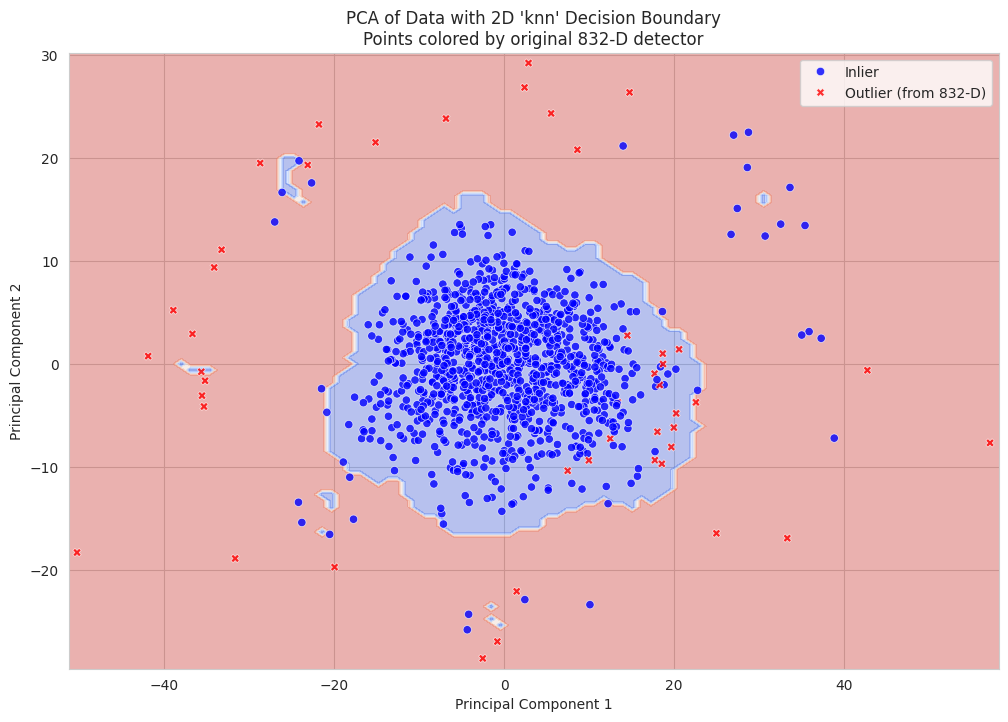

--- Visualizing: zscore ---
Using z-score detector (stateful, mean-based, threshold=1)
INFO: OutlierDetector.ZSCORE (on train data) found 5 outliers. Keeping 1207 / 1212 samples.


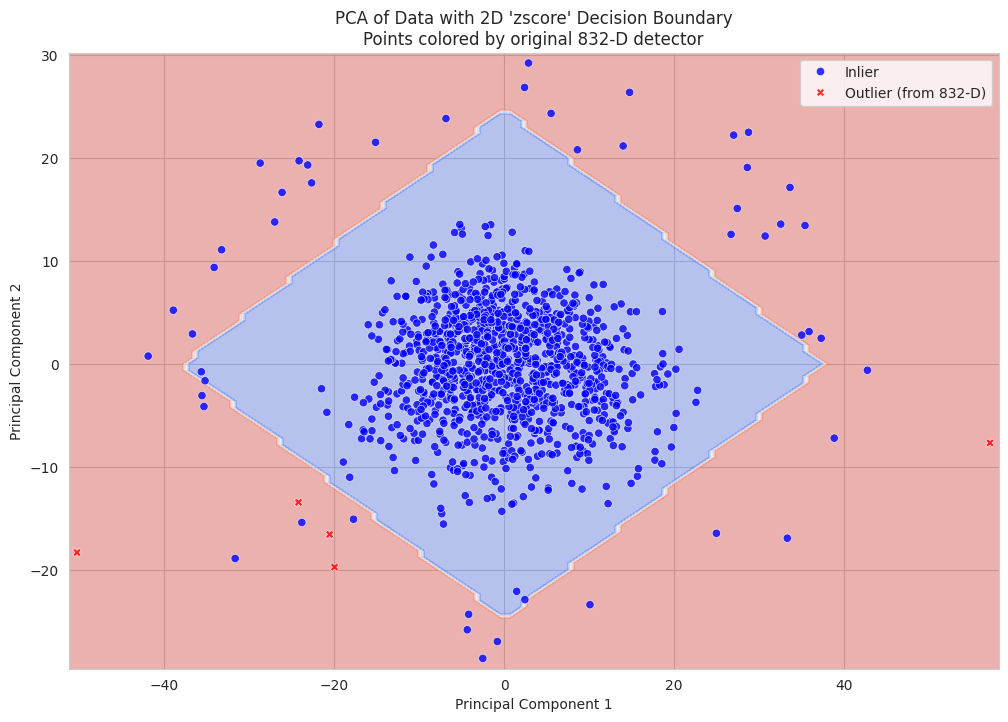

--- Visualizing: svm ---
Using One-Class SVM (stateful, nu=0.05)
INFO: OutlierDetector.SVM (on train data) found 60 outliers. Keeping 1152 / 1212 samples.


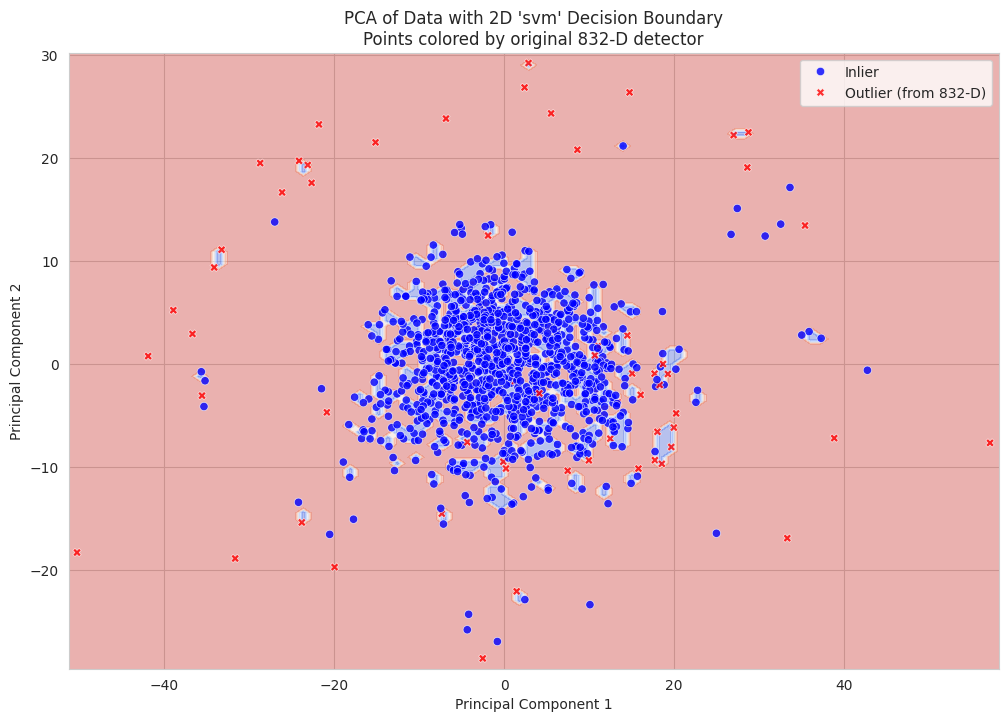

--- Visualizing: pca_svm ---
Using PCA+SVM detector (stateful, n_components=2, nu=0.05, gamma=0.0003)
INFO: OutlierDetector.PCA_SVM (on train data) found 61 outliers. Keeping 1151 / 1212 samples.


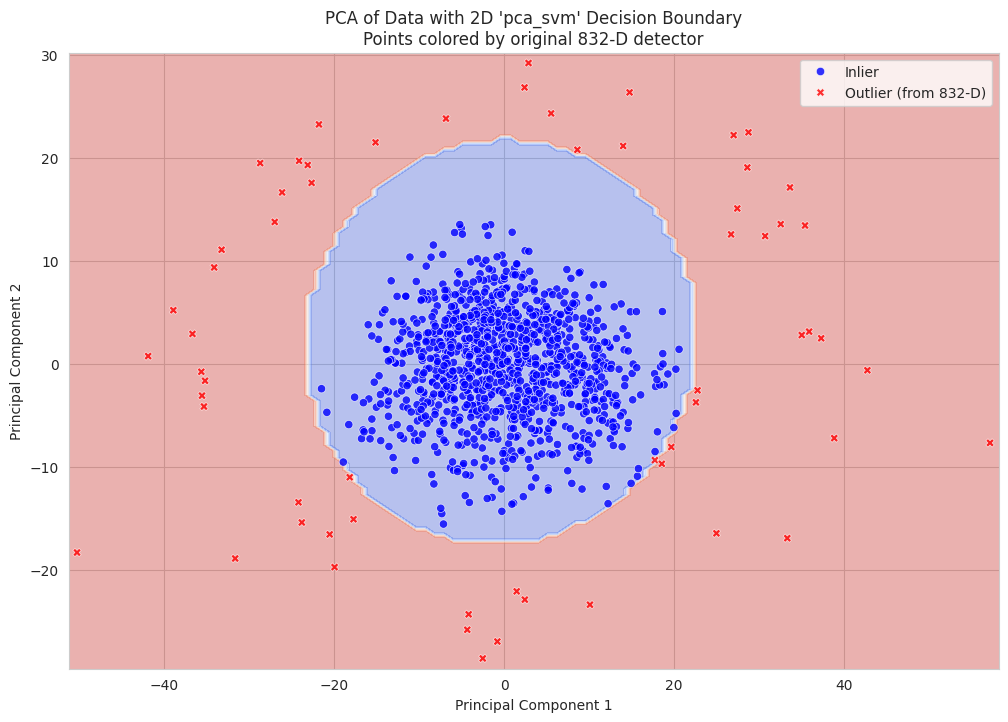

--- Visualizing: pca_isoforest ---
Using PCA+IsolationForest detector (stateful, n_components=2, contamination=0.045)
INFO: OutlierDetector.PCA_ISOFOREST (on train data) found 55 outliers. Keeping 1157 / 1212 samples.


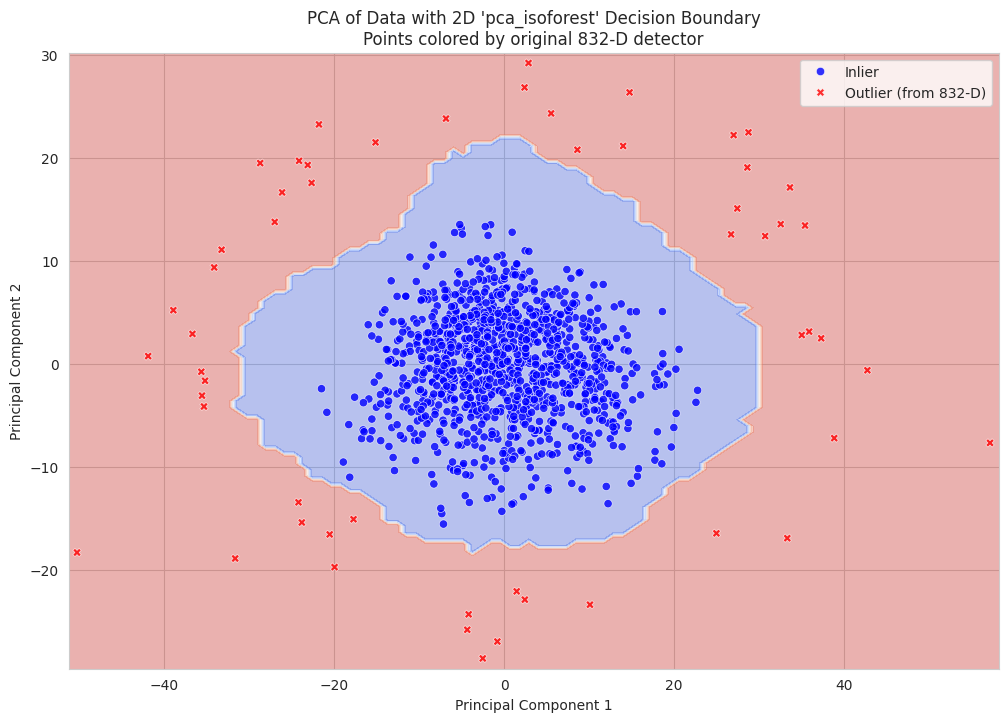

In [17]:
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.ISOFOREST, configs)
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.KNN, configs)
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.ZSCORE, configs)
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.SVM, configs)
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.PCA_SVM, configs)
plot_pca_boundary(X_imputed, y_training_data, OutlierDetector.PCA_ISOFOREST, configs)